In [1]:
# 1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.
# 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.
# 3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).
# 4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH.
#    Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).
# 5. Сравните объем памяти исходного и сжатого изображения.

In [2]:
import numpy as np
import cv2
import os
from collections import Counter
import matplotlib.pyplot as plt

# Загрузка изображения

In [3]:
img = cv2.imread('sar_1_gray.jpg', 0)

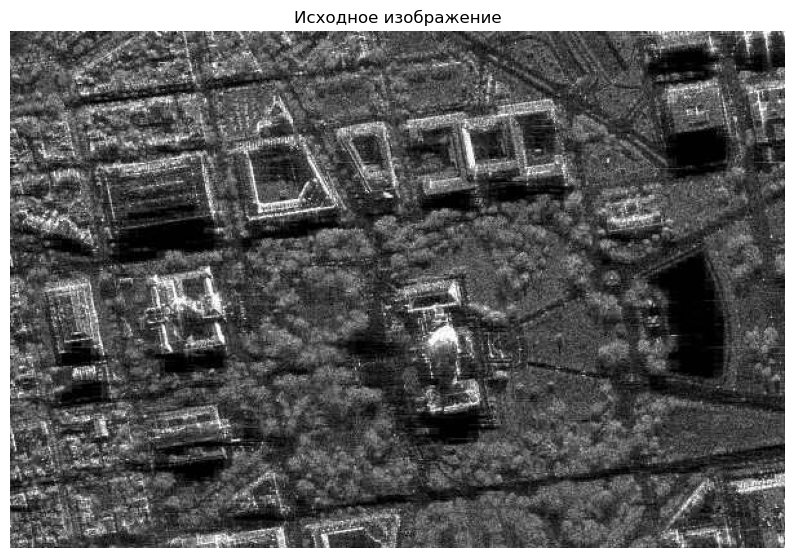

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

In [5]:
print(f'Размер изображения: {img.shape}')
print(f'Количество пикселей: {img.size}')
print(f'Тип данных: {img.dtype}')
print(f'Диапазон значений: [{img.min()}, {img.max()}]')

Размер изображения: (400, 600)
Количество пикселей: 240000
Тип данных: uint8
Диапазон значений: [0, 255]


# 1. Сохранение монохромного изображения в текстовый файл

In [6]:
np.savetxt('original.txt', img, fmt='%d')

In [7]:
original_file_size = os.path.getsize('original.txt')
original_memory_size = img.nbytes

In [8]:
print(f'Размер файла original.txt: {original_file_size} байт')
print(f'Размер в памяти (пиксели): {original_memory_size} байт')
print(f'Количество пикселей: {img.size}')

Размер файла original.txt: 765222 байт
Размер в памяти (пиксели): 240000 байт
Количество пикселей: 240000


# 2. Реализация алгоритма вейвлет-преобразования Хаара

In [9]:
def haar_transform(image):
    """
    Вейвлет-преобразование Хаара для изображения
    
    Returns:
    --------
    LL : numpy.ndarray - Низкочастотная компонента (приближение)
    LH : numpy.ndarray - Горизонтальные детали
    HL : numpy.ndarray - Вертикальные детали
    HH : numpy.ndarray - Диагональные детали
    """
    image = image.astype(np.float32)
    
    rows, cols = image.shape
    
    # Обрезка до четных размеров
    if rows % 2 != 0 or cols % 2 != 0:
        image = image[:rows//2*2, :cols//2*2]
        rows, cols = image.shape
    
    # Преобразование по строкам
    row_transform = np.zeros_like(image, dtype=np.float32)
    for i in range(rows):
        for j in range(0, cols - 1, 2):
            # Среднее (низкие частоты)
            row_transform[i, j // 2] = (image[i, j] + image[i, j + 1]) / 2.0
            # Разность (высокие частоты)
            row_transform[i, (j // 2) + cols // 2] = (image[i, j] - image[i, j + 1]) / 2.0
    
    # Преобразование по столбцам
    result = np.zeros_like(row_transform, dtype=np.float32)
    for j in range(cols):
        for i in range(0, rows - 1, 2):
            # Среднее (низкие частоты)
            result[i // 2, j] = (row_transform[i, j] + row_transform[i + 1, j]) / 2.0
            # Разность (высокие частоты)
            result[(i // 2) + rows // 2, j] = (row_transform[i, j] - row_transform[i + 1, j]) / 2.0
    
    # Разделение на компоненты
    LL = result[:rows // 2, :cols // 2]    # Приближение
    LH = result[:rows // 2, cols // 2:]    # Горизонтальные детали
    HL = result[rows // 2:, :cols // 2]    # Вертикальные детали
    HH = result[rows // 2:, cols // 2:]    # Диагональные детали
    
    return LL, LH, HL, HH

In [10]:
LL, LH, HL, HH = haar_transform(img)

In [11]:
print(f'LL (приближение): {LL.shape}')
print(f'LH (горизонтальные детали): {LH.shape}')
print(f'HL (вертикальные детали): {HL.shape}')
print(f'HH (диагональные детали): {HH.shape}')

LL (приближение): (200, 300)
LH (горизонтальные детали): (200, 300)
HL (вертикальные детали): (200, 300)
HH (диагональные детали): (200, 300)


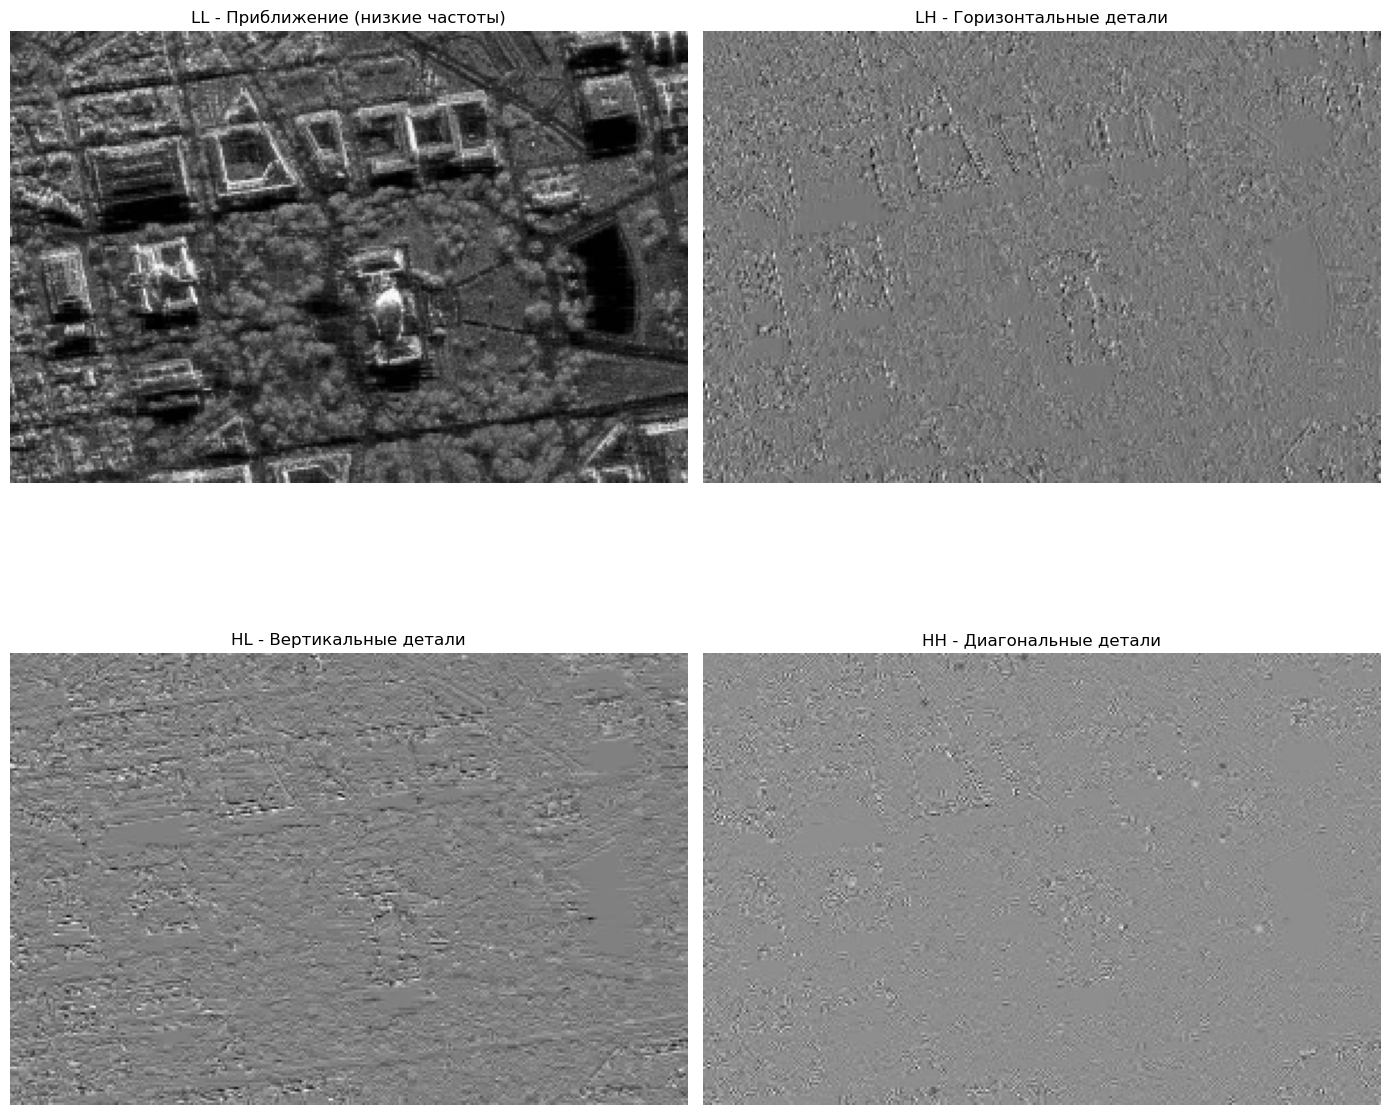

In [12]:
# Визуализация компонент вейвлет-преобразования
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].imshow(LL, cmap='gray')
axes[0, 0].set_title('LL - Приближение (низкие частоты)')
axes[0, 0].axis('off')

axes[0, 1].imshow(LH, cmap='gray')
axes[0, 1].set_title('LH - Горизонтальные детали')
axes[0, 1].axis('off')

axes[1, 0].imshow(HL, cmap='gray')
axes[1, 0].set_title('HL - Вертикальные детали')
axes[1, 0].axis('off')

axes[1, 1].imshow(HH, cmap='gray')
axes[1, 1].set_title('HH - Диагональные детали')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Статистика по компонентам
print('Статистика компонент:')
print(f'LL: min={LL.min():.2f}, max={LL.max():.2f}, mean={LL.mean():.2f}')
print(f'LH: min={LH.min():.2f}, max={LH.max():.2f}, mean={LH.mean():.2f}')
print(f'HL: min={HL.min():.2f}, max={HL.max():.2f}, mean={HL.mean():.2f}')
print(f'HH: min={HH.min():.2f}, max={HH.max():.2f}, mean={HH.mean():.2f}')

Статистика компонент:
LL: min=0.00, max=254.50, mean=74.94
LH: min=-86.00, max=97.50, mean=-0.03
HL: min=-90.50, max=89.50, mean=0.09
HH: min=-67.00, max=53.25, mean=-0.01


# 3. Квантование высокочастотных компонент

In [14]:
quants = 4  # Количество квантов

In [15]:
def quantize(coeffs, num_quants):
    """
    Квантование коэффициентов
    
    Parameters:
    -----------
    coeffs : numpy.ndarray
        Массив коэффициентов для квантования
    num_quants : int
        Количество квантов
    
    Returns:
    --------
    quantized : numpy.ndarray
        Квантованные коэффициенты (целые числа от 0 до num_quants-1)
    """
    min_val = np.min(coeffs)
    max_val = np.max(coeffs)
    
    if max_val == min_val:
        return np.zeros_like(coeffs, dtype=int)
    
    # Шаг квантования
    step = (max_val - min_val) / num_quants
    
    # Квантование
    quantized = np.floor((coeffs - min_val) / step).astype(int)
    
    # Ограничение значений
    quantized = np.clip(quantized, 0, num_quants - 1)
    
    return quantized

In [16]:
# Квантование высокочастотных компонент
LH_q = quantize(LH, quants)
HL_q = quantize(HL, quants)
HH_q = quantize(HH, quants)

In [17]:
print(f'Уникальные значения после квантования:')
print(f'LH_q: {np.unique(LH_q)}')
print(f'HL_q: {np.unique(HL_q)}')
print(f'HH_q: {np.unique(HH_q)}')

Уникальные значения после квантования:
LH_q: [0 1 2 3]
HL_q: [0 1 2 3]
HH_q: [0 1 2 3]


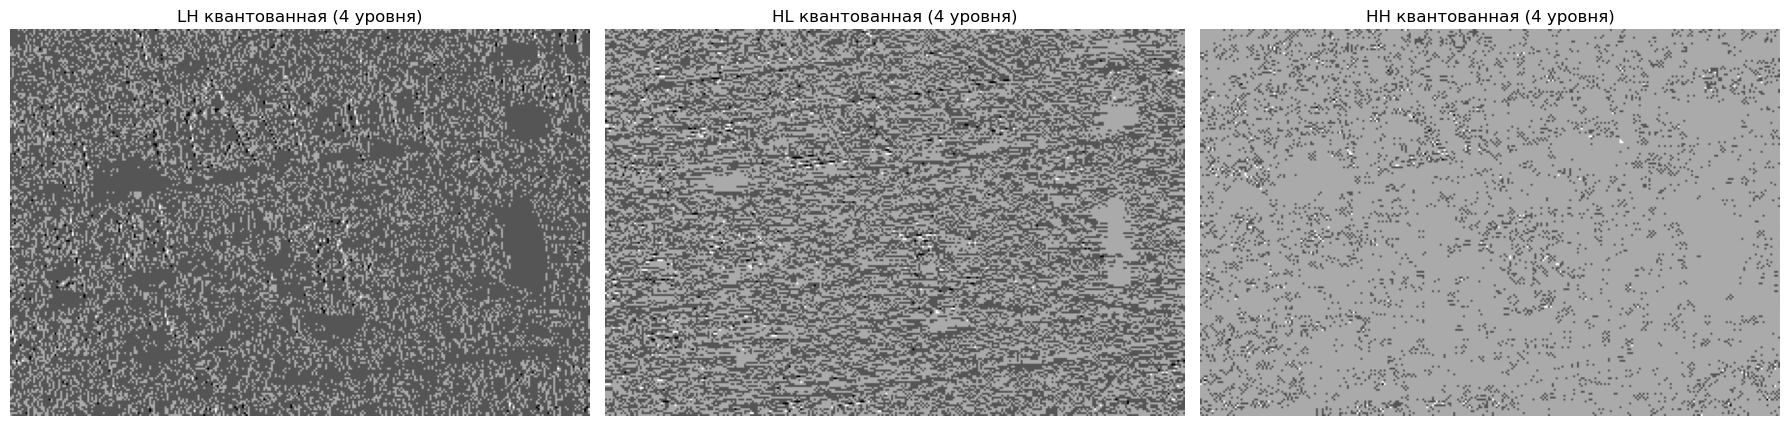

In [18]:
# Визуализация квантованных компонент
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(LH_q, cmap='gray')
axes[0].set_title(f'LH квантованная ({quants} уровня)')
axes[0].axis('off')

axes[1].imshow(HL_q, cmap='gray')
axes[1].set_title(f'HL квантованная ({quants} уровня)')
axes[1].axis('off')

axes[2].imshow(HH_q, cmap='gray')
axes[2].set_title(f'HH квантованная ({quants} уровня)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 4. Сжатие методом RLE (Run-Length Encoding)

In [19]:
def run_length_encode(data):
    """
    Кодирование длин серий (RLE)
    Возвращает пары (значение, количество повторений)
    """
    encoded = []
    counter = Counter(data.flatten())
    for value, count in counter.items():
        encoded.append((value, count))
    return encoded

In [20]:
# Кодирование квантованных компонент
LH_rle = run_length_encode(LH_q)
HL_rle = run_length_encode(HL_q)
HH_rle = run_length_encode(HH_q)

In [21]:
print(f'RLE для LH: {len(LH_rle)} пар')
print(f'Примеры: {LH_rle[:5]}')
print(f'\nRLE для HL: {len(HL_rle)} пар')
print(f'Примеры: {HL_rle[:5]}')
print(f'\nRLE для HH: {len(HH_rle)} пар')
print(f'Примеры: {HH_rle[:5]}')

RLE для LH: 4 пар
Примеры: [(np.int64(1), 43977), (np.int64(2), 15542), (np.int64(0), 348), (np.int64(3), 133)]

RLE для HL: 4 пар
Примеры: [(np.int64(1), 27290), (np.int64(2), 32171), (np.int64(3), 274), (np.int64(0), 265)]

RLE для HH: 4 пар
Примеры: [(np.int64(2), 53899), (np.int64(1), 5840), (np.int64(3), 244), (np.int64(0), 17)]


In [22]:
# Сохранение в файл: LL без сжатия, LH/HL/HH с RLE
with open('result.txt', 'w') as f:
    # LL компонента (без квантования и сжатия)
    f.write('# LL component\n')
    np.savetxt(f, LL, fmt='%.2f')
    f.write('\n')
    
    # LH компонента (RLE)
    f.write('# LH component (value, count)\n')
    for value, count in LH_rle:
        f.write(f'{value} {count}\n')
    f.write('\n')
    
    # HL компонента (RLE)
    f.write('# HL component (value, count)\n')
    for value, count in HL_rle:
        f.write(f'{value} {count}\n')
    f.write('\n')
    
    # HH компонента (RLE)
    f.write('# HH component (value, count)\n')
    for value, count in HH_rle:
        f.write(f'{value} {count}\n')

In [23]:
print('Сохранено в result.txt')

Сохранено в result.txt


# 5. Сравнение объемов памяти

In [24]:
compressed_size = os.path.getsize('result.txt')

In [25]:
print('='*60)
print('СРАВНЕНИЕ РАЗМЕРОВ')
print('='*60)
print(f'Исходное изображение (текстовый файл): {original_file_size:,} байт')
print(f'Сжатое изображение (Haar + RLE):      {compressed_size:,} байт')
print('-'*60)
print(f'Степень сжатия: {original_file_size / compressed_size:.2f}x')
print(f'Экономия памяти: {(1 - compressed_size/original_file_size)*100:.2f}%')
print('='*60)

СРАВНЕНИЕ РАЗМЕРОВ
Исходное изображение (текстовый файл): 765,222 байт
Сжатое изображение (Haar + RLE):      371,196 байт
------------------------------------------------------------
Степень сжатия: 2.06x
Экономия памяти: 51.49%


In [26]:
# Детальная статистика
print('\nДетальная информация:')
print(f'  Размер LL компоненты: {LL.size} значений')
print(f'  Размер LH после RLE: {len(LH_rle)} пар')
print(f'  Размер HL после RLE: {len(HL_rle)} пар')
print(f'  Размер HH после RLE: {len(HH_rle)} пар')
print(f'\nСтепень сжатия высокочастотных компонент:')
print(f'  LH: {LH_q.size} → {len(LH_rle)} ({LH_q.size/len(LH_rle):.2f}x)')
print(f'  HL: {HL_q.size} → {len(HL_rle)} ({HL_q.size/len(HL_rle):.2f}x)')
print(f'  HH: {HH_q.size} → {len(HH_rle)} ({HH_q.size/len(HH_rle):.2f}x)')


Детальная информация:
  Размер LL компоненты: 60000 значений
  Размер LH после RLE: 4 пар
  Размер HL после RLE: 4 пар
  Размер HH после RLE: 4 пар

Степень сжатия высокочастотных компонент:
  LH: 60000 → 4 (15000.00x)
  HL: 60000 → 4 (15000.00x)
  HH: 60000 → 4 (15000.00x)


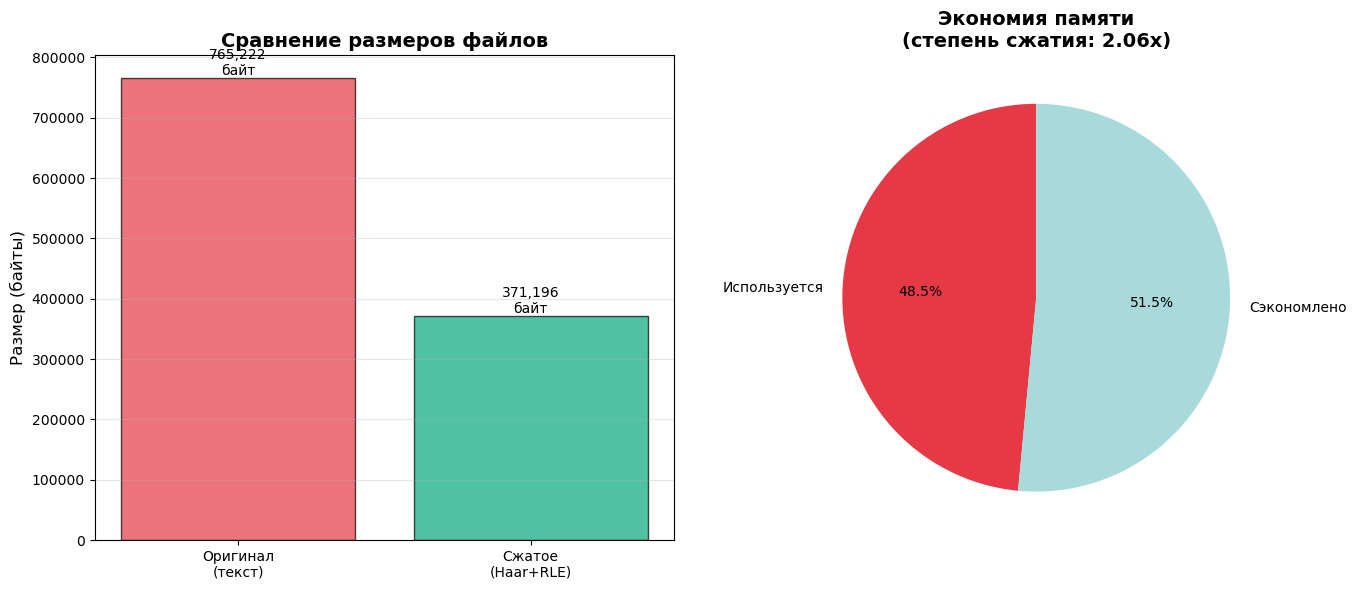

In [27]:
# Визуализация сравнения размеров
sizes = [original_file_size, compressed_size]
labels = ['Оригинал\n(текст)', 'Сжатое\n(Haar+RLE)']
colors = ['#E63946', '#06A77D']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Столбчатая диаграмма
ax1.bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Размер (байты)', fontsize=12)
ax1.set_title('Сравнение размеров файлов', fontsize=14, weight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, (label, size) in enumerate(zip(labels, sizes)):
    ax1.text(i, size, f'{size:,}\nбайт', ha='center', va='bottom', fontsize=10)

# Круговая диаграмма
ax2.pie([compressed_size, original_file_size - compressed_size], 
        labels=['Используется', 'Сэкономлено'],
        autopct='%1.1f%%',
        colors=['#E63946', '#A8DADC'],
        startangle=90)
ax2.set_title(f'Экономия памяти\n(степень сжатия: {original_file_size/compressed_size:.2f}x)', 
             fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# Дополнительно: Тестирование разного количества квантов

In [28]:
# Эксперимент с разными уровнями квантования
quant_levels = [2, 4, 8, 16]

In [29]:
compression_results = []

for q in quant_levels:
    # Квантование
    LH_q_test = quantize(LH, q)
    HL_q_test = quantize(HL, q)
    HH_q_test = quantize(HH, q)
    
    # RLE
    LH_rle_test = run_length_encode(LH_q_test)
    HL_rle_test = run_length_encode(HL_q_test)
    HH_rle_test = run_length_encode(HH_q_test)
    
    # Примерная оценка размера
    # LL без сжатия + RLE для LH, HL, HH
    estimated_size = (LL.size * 8) + (len(LH_rle_test) + len(HL_rle_test) + len(HH_rle_test)) * 16
    
    compression_results.append({
        'quants': q,
        'size': estimated_size,
        'ratio': original_memory_size / estimated_size
    })
    
    print(f'Квантов: {q:2d} | Размер: {estimated_size:7d} байт | Сжатие: {original_memory_size/estimated_size:.2f}x')

Квантов:  2 | Размер:  480096 байт | Сжатие: 0.50x
Квантов:  4 | Размер:  480192 байт | Сжатие: 0.50x
Квантов:  8 | Размер:  480384 байт | Сжатие: 0.50x
Квантов: 16 | Размер:  480752 байт | Сжатие: 0.50x


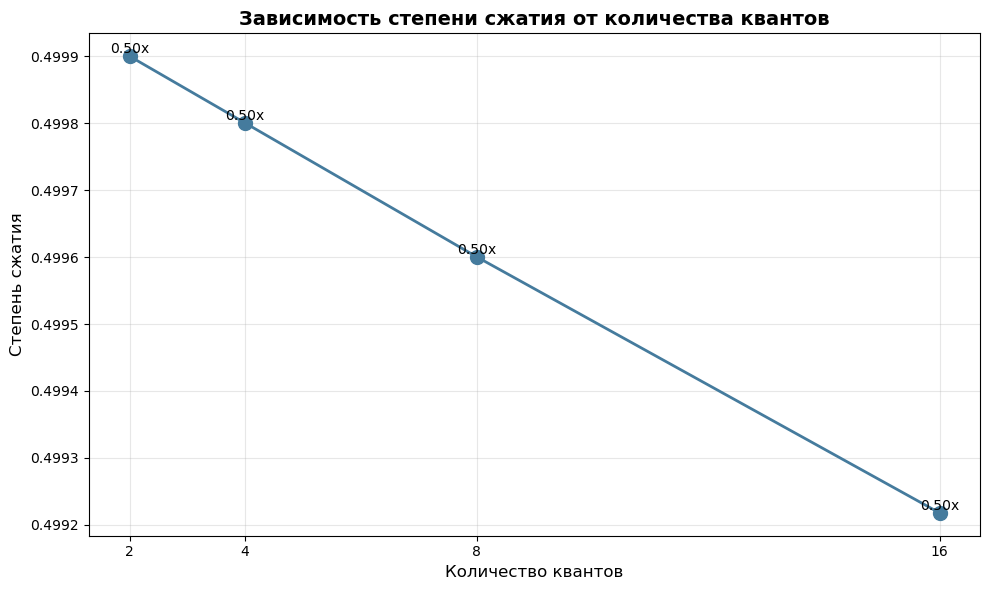

In [30]:
# График зависимости степени сжатия от количества квантов
quants_arr = [r['quants'] for r in compression_results]
ratios = [r['ratio'] for r in compression_results]

plt.figure(figsize=(10, 6))
plt.plot(quants_arr, ratios, 'o-', linewidth=2, markersize=10, color='#457B9D')
plt.xlabel('Количество квантов', fontsize=12)
plt.ylabel('Степень сжатия', fontsize=12)
plt.title('Зависимость степени сжатия от количества квантов', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(quants_arr)

for q, r in zip(quants_arr, ratios):
    plt.text(q, r, f'{r:.2f}x', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [31]:
print('\n' + '='*70)
print('ВЫВОДЫ')
print('='*70)
print(f'''
1. ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЕ ХААРА:
   • Разделяет изображение на 4 компоненты: LL, LH, HL, HH
   • LL содержит основную информацию (приближение)
   • LH, HL, HH содержат детали (высокие частоты)

2. КВАНТОВАНИЕ:
   • Количество квантов: {quants}
   • Уменьшает количество уникальных значений
   • Позволяет эффективно сжимать данные

3. RLE СЖАТИЕ:
   • LH: {LH_q.size} → {len(LH_rle)} пар ({LH_q.size/len(LH_rle):.1f}x)
   • HL: {HL_q.size} → {len(HL_rle)} пар ({HL_q.size/len(HL_rle):.1f}x)
   • HH: {HH_q.size} → {len(HH_rle)} пар ({HH_q.size/len(HH_rle):.1f}x)

4. ИТОГОВОЕ СЖАТИЕ:
   • Исходный размер: {original_file_size:,} байт
   • Сжатый размер: {compressed_size:,} байт
   • Степень сжатия: {original_file_size/compressed_size:.2f}x
   • Экономия: {(1-compressed_size/original_file_size)*100:.1f}%

5. РЕКОМЕНДАЦИИ:
   • Больше квантов = меньше сжатие, но лучше качество
   • Меньше квантов = больше сжатие, но хуже качество
   • Оптимальное количество квантов зависит от задачи
''')
print('='*70)


ВЫВОДЫ

1. ВЕЙВЛЕТ-ПРЕОБРАЗОВАНИЕ ХААРА:
   • Разделяет изображение на 4 компоненты: LL, LH, HL, HH
   • LL содержит основную информацию (приближение)
   • LH, HL, HH содержат детали (высокие частоты)

2. КВАНТОВАНИЕ:
   • Количество квантов: 4
   • Уменьшает количество уникальных значений
   • Позволяет эффективно сжимать данные

3. RLE СЖАТИЕ:
   • LH: 60000 → 4 пар (15000.0x)
   • HL: 60000 → 4 пар (15000.0x)
   • HH: 60000 → 4 пар (15000.0x)

4. ИТОГОВОЕ СЖАТИЕ:
   • Исходный размер: 765,222 байт
   • Сжатый размер: 371,196 байт
   • Степень сжатия: 2.06x
   • Экономия: 51.5%

5. РЕКОМЕНДАЦИИ:
   • Больше квантов = меньше сжатие, но лучше качество
   • Меньше квантов = больше сжатие, но хуже качество
   • Оптимальное количество квантов зависит от задачи

